In [1]:
!pip install pathy -q
!pip install wandb -q

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image


In [3]:
import requests
r = requests.get('https://ipinfo.io')
region = r.json()['region']
r.json()

{'city': 'The Dalles',
 'country': 'US',
 'hostname': '184.123.230.35.bc.googleusercontent.com',
 'ip': '35.230.123.184',
 'loc': '45.5946,-121.1787',
 'org': 'AS15169 Google LLC',
 'postal': '97058',
 'readme': 'https://ipinfo.io/missingauth',
 'region': 'Oregon',
 'timezone': 'America/Los_Angeles'}

In [4]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

parser.add_argument('-dim', '--d_model', default=256, type=int)
parser.add_argument('-nh', '--num_heads', default=4, type=int)
parser.add_argument('-nl', '--num_layers', default=6, type=int)
parser.add_argument('-sl', '--sequence_length', default=128, type=int)
parser.add_argument('-dr', '--dropout_rate', type=float, default=0.1)
parser.add_argument('-cl', '--grad_clip_value', type=float, default=0.25)
parser.add_argument('-ds', '--distributed', type=bool, default=False)


### Sample local config
args = parser.parse_args('''
dummy_run2 
--train_dataset train
--test_dataset test
-c
-s GCS
--bucket_name artificial_graphics
'''.split())


In [5]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/artificial_graphics' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading data from Google Cloud Storage
Storage path: gs://artificial_graphics/


In [6]:
!git pull
from importlib import reload
reload(lib)
# reload(lib.data)

Already up to date.


<module 'lib' (namespace)>

In [7]:
import tensorflow_datasets as tfds
import lib
import lib.data

train_dl = lib.data.dataloader(TRAIN_DATA_PATHS, batch_size = 8, inception_prepro=True) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
train_dataset = iter(train_dl.dataset)
test_dl = lib.data.dataloader(TEST_DATA_PATHS, batch_size = 8, inception_prepro=True) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
test_dataset = iter(test_dl.dataset)

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [9]:
# Feel free to change these parameters according to your system's configuration

BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 6 # TODO Change
num_steps = 10000
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [10]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [11]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [12]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [13]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [15]:
import wandb
wandb.init(project="artificial_graphics")
wandb.run.name = args.run_name
t = 0

wandb: Currently logged in as: sholto (use `wandb login --relogin` to force relogin)


In [16]:
checkpoint_path = str(STORAGE_PATH/f'saved_models/{args.run_name}')
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [17]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [23]:
def accuracy(real, pred):
  
  padding = tf.cast(real != 0, tf.float32)
  pred = tf.cast(tf.squeeze(tf.random.categorical(pred, 1)), tf.int32)
  # print(padding*pred, padding)
  
  correct = tf.cast(real == pred, tf.float32)
  return tf.reduce_sum(correct*padding) / tf.reduce_sum(padding) # multiply by padding to 0 out anything which is a pad and then divide by it to get dividue by non pads e.g ./5


@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([1] * target.shape[0], 1)

  img_features = image_features_extract_model(img_tensor)
  img_features = tf.reshape(img_features, (img_features.shape[0], -1, img_features.shape[3]))

  metrics = {}
  with tf.GradientTape() as tape:
      features = encoder(img_features)

      for i in range(0, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          metrics[f"train_acc_step_{i}"] =  accuracy(target[:,i], predictions)
          
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)


  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))


  metrics['train_loss'] =  (loss / int(target.shape[1]))


  return metrics

@tf.function
def step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([1] * target.shape[0], 1)

  img_features = image_features_extract_model(img_tensor)
  img_features = tf.reshape(img_features, (img_features.shape[0], -1, img_features.shape[3]))


  features = encoder(img_features)
  metrics = {}
  for i in range(0, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)
      metrics[f"test_acc_step_{i}"] =  accuracy(target[:,i], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)


  metrics['test_loss'] =  loss / int(target.shape[1])
  return metrics


In [22]:
# data = train_dataset.next()
# metrics = train_step(data['img'], data['target'])

In [24]:

for data in train_dataset:
    train_metrics = train_step(data['img'], data['target'])

    if t % 100 == 0:
        test_data = test_dataset.next()
        test_metrics = step(test_data['img'], test_data['target'])
        print(f'Batch {t} Loss {train_metrics["train_loss"]:.4f} Valid loss {test_metrics["test_loss"]:.4f}')
        wandb.log(train_metrics, step=t)
        wandb.log(test_metrics, step=t)
    if t % 1000 == 0:
      ckpt_manager.save()
    t += 1


Batch 0 Loss 0.9647 Valid loss 0.7970
Batch 100 Loss 0.2871 Valid loss 0.5000
Batch 200 Loss 0.1882 Valid loss 0.2239
Batch 300 Loss 0.1602 Valid loss 0.0964
Batch 400 Loss 0.1267 Valid loss 0.0676
Batch 500 Loss 0.1702 Valid loss 0.0366
Batch 600 Loss 0.0227 Valid loss 0.0993
Batch 700 Loss 0.0404 Valid loss 0.0000
Batch 800 Loss 0.0057 Valid loss 0.0136
Batch 900 Loss 0.1917 Valid loss 0.0883
Batch 1000 Loss 0.0037 Valid loss 0.0911
Batch 1100 Loss 0.0465 Valid loss 0.0007
Batch 1200 Loss 0.0074 Valid loss 0.0011
Batch 1300 Loss 0.0291 Valid loss 0.0157
Batch 1400 Loss 0.0011 Valid loss 0.0164
Batch 1500 Loss 0.0235 Valid loss 0.0007
Batch 1600 Loss 0.0160 Valid loss 0.0120
Batch 1700 Loss 0.0004 Valid loss 0.0003
Batch 1800 Loss 0.0007 Valid loss 0.0359
Batch 1900 Loss 0.0005 Valid loss 0.0097
Batch 2000 Loss 0.0209 Valid loss 0.0012
Batch 2100 Loss 0.0047 Valid loss 0.0063
Batch 2200 Loss 0.0008 Valid loss 0.0008


KeyboardInterrupt: ignored

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [25]:
max_length = data['target'].shape[1]
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([1], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(str(predicted_id))

        if predicted_id == 3:
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ff9a262c1d0>> (for pre_run_cell):


Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ff9a262c1d0>> (for post_run_cell):


Exception: ignored

In [21]:
def plot_attention(img, result, attention_plot):
    temp_image = np.array(img)

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

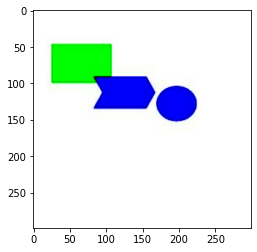

In [24]:
data = train_dataset.next()
image = data['img'][0]
plt.imshow(image)

Prediction Caption: 4 5 2 4 2


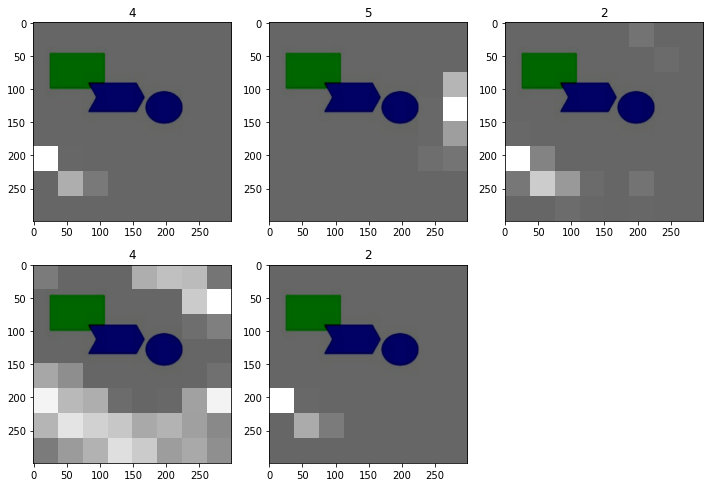

In [25]:
# captions on the validation set

# real_caption = ' '.join([tokenizer.index_word[i]
#                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.